## CSE 572 Assignment 3 
#### Written By: Sam Steinberg | Graduate Student at Arizona State University

*-- START OF FUNCTIONS --*

In [1]:
#Getting tm times:
def get_tm_times(ins_df):
    tm_list_date = []
    tm_list_time = []
    tm_list_row = []

    for i in range(len(ins_df),0,-1):
        if(np.isnan(ins_df.loc[i-1,"BWZ Carb Input (grams)"]) == False): #Searching "Y" column for non NAN values
            if(i-1 < len(ins_df) - 7): #Catching index out of bounds error
                tm_list_date.append(ins_df.loc[i-1+6 ,"Date"]) #appending start date (tm - 30min)
                tm_list_date.append(ins_df.loc[i-1-24,"Date"])#appending end date (2 hours later)

                tm_list_time.append(ins_df.loc[i-1+6,"Time"]) #appending start time (t - 30min)
                tm_list_time.append(ins_df.loc[i-1-24,"Time"]) #appending end time (tm + 2hrs)

                tm_list_row.append(i-1+6) #appending start row (t - 30min)
                tm_list_row.append(i-1-24) #appending end row (tm + 2hrs)
        
    return tm_list_date, tm_list_time, tm_list_row

In [2]:
def indicate_meal_boundaries(tm_list_date, tm_list_time, tm_list_row):
    #3 conditions:
    meal = False
    for i in range(0, len(tm_list_row), 2): 
        for j in range(1, 25): #Checking next 2 hours for a meal:
            if(np.isnan(ins_P1.loc[tm_list_row[i] - j - 6, "BWZ Carb Input (grams)"]) == False):
                meal = True #There is another meal, so a) condition fails
                #Handling condition b)
                tm_list_date[i] = ins_P1.loc[tm_list_row[i] - j, "Date"] #appending new start date of meal
                tm_list_date[i+1] = ins_P1.loc[tm_list_row[i] - j - 30, "Date"] #appending new end date of meal

                tm_list_time[i] = ins_P1.loc[tm_list_row[i] - j, "Time"] #appending new start time of meal
                tm_list_time[i+1] = ins_P1.loc[tm_list_row[i] - j - 30, "Time"] #appending new end time of meal

                tm_list_row[i] = tm_list_row[i] - j #appending new start row of meal
                tm_list_row[i+1] = tm_list_row[i] - 30 #appending new end row of meal
                break
            if(j == 24 and np.isnan(ins_P1.loc[tm_list_row[i] - j - 6, "BWZ Carb Input (grams)"]) == False): 
                #Handling condition c) #18 is tm + 1hr 30min, 48 is tm + hrs
                tm_list_date[i] = ins_P1.loc[tm_list_row[i] - j - 18, "Date"] #appending new start date of meal
                tm_list_date[i+1] = ins_P1.loc[tm_list_row[i] - 48 , "Date"] #appending new end date of meal

                tm_list_time[i] = ins_P1.loc[tm_list_row[i] - j - 18, "Time"] #appending new start time of meal
                tm_list_time[i+1] = ins_P1.loc[tm_list_row[i] - 48, "Time"] #appending new end time of meal

                tm_list_row[i] = tm_list_row[i] - 18 #appending new start row of meal
                tm_list_row[i+1] = tm_list_row[i] - 30 #appending new end row of meal
    return tm_list_date, tm_list_time, tm_list_row

In [3]:
def extract_features(meal_list_date, meal_list_time, meal_list_row, cgm_DF):
    means = [] #Columns: mean, sd, ground truth value
    sds = []
    ground_truths = []
    
    #Collecting cgm data of meals
    for i in range(0, len(meal_list_row) - 1, 2):
        meal_data = []
        j = meal_list_row[i]
        while(j != meal_list_row[i+1] and j >= 0):
            if(math.isnan(cgm_DF.loc[j, "Sensor Glucose (mg/dL)"]) == True):
                pass
                #nan value, so don't append it
            else:
                meal_data.append(cgm_DF.loc[j, "Sensor Glucose (mg/dL)"])
            j = j-1 #decrementing j
            
        #Getting mean and sd of set of data and ground truth
        if(len(meal_data) > 0):
            mean = float(sum(meal_data) / len(meal_data))
            sd = np.std(meal_data, ddof=0)
            means.append(mean)
            sds.append(sd)
            ground_truths.append(1) #1 equals meal and 0 equals no meal
            
    return means, sds, ground_truths

In [4]:
def create_features_df(means,sds,ground_truths):
    #creating feature dataframe
    data = {'mean': means,
            'sd': sds,
            'ground_truth': ground_truths
            }
    
    features_df = pd.DataFrame(data, columns = ['mean','sd', 'ground_truth'])
    
    return features_df

In [5]:
#Deriving min (min can't be zero though) and max values of meal intake amount from Y coloumn
def find_Min_Max(ins_df):
    first_num_found = False
    y_list = []
    
    for i in range(0, len(ins_df)):
        if(first_num_found == False and np.isnan(ins_df.loc[i,"BWZ Carb Input (grams)"]) == False):
            if(ins_df.loc[i,"BWZ Carb Input (grams)"] > 0):
                minimum = ins_df.loc[i, "BWZ Carb Input (grams)"]
                maximum = ins_df.loc[i, "BWZ Carb Input (grams)"]
                first_num_found = True #We have retrieved the first number in the Y column   
                y_list.append(ins_df.loc[i, "BWZ Carb Input (grams)"])
        if(first_num_found == True):
            index_val = ins_df.loc[i, "BWZ Carb Input (grams)"]
            
            if(index_val > 0 and np.isnan(index_val) == False ):
                y_list.append(index_val)
                if(index_val > maximum):
                    maximum = index_val
                if(index_val < minimum):
                    minimum = index_val  
    return minimum, maximum, y_list

In [6]:
def discretize(minimum, maximum, meal_list_row, y_list):
    y_list_discretized = []
    
    #Finding number of bins
    n = int((maximum - minimum) / 20) #Rounding down

    #Discritizing y column values based on the n value (in this case, 6):
    y_list_discretized = np.digitize(y_list,bins=[20,40,60,80,100]) #We have 6 bins of a range (size) of 20
    
    return n, y_list_discretized

In [7]:
def preprocessing(feature_df):
    #Scaling the data to bring all the attributes to a comparable level 
    scaler = StandardScaler() 
    X_scaled = scaler.fit_transform(features_df) 

    # Normalizing the data so that  
    # the data approximately follows a Gaussian distribution 
    X_normalized = normalize(X_scaled) 

    # Converting the numpy array into a pandas DataFrame 
    X_normalized = pd.DataFrame(X_normalized) 
    
    #Reducing dimensionality
    pca = PCA(n_components = 2) 
    X_principal = pca.fit_transform(X_normalized) 
    X_principal = pd.DataFrame(X_principal) 
    X_principal.columns = ['mean', 'sd'] 
    #print(X_principal.head()) 
    
    return X_principal

In [8]:
def dbscan(X_principal, y_list_discretized):
    #Numpy array of all the cluster labels assigned to each data point 
    db_default = DBSCAN(eps = 0.0639, min_samples = 6).fit(X_principal) #Best: eps = 0.0639, min_samples = 6
    labels = db_default.labels_ 
    #Building labels for color mapping
    colors = {} 
    colors[0] = 'r'
    colors[1] = 'g'
    colors[2] = 'b'
    colors[3] = 'c'
    colors[4] = 'y'
    colors[5] = 'm'

    cvec = [colors[label] for label in labels] 

    #For the construction of the legend of the plot 
    r = plt.scatter(X_principal['mean'], X_principal['sd'], color ='r'); 
    g = plt.scatter(X_principal['mean'], X_principal['sd'], color ='g'); 
    b = plt.scatter(X_principal['mean'], X_principal['sd'], color ='b'); 
    c = plt.scatter(X_principal['mean'], X_principal['sd'], color ='c'); 
    y = plt.scatter(X_principal['mean'], X_principal['sd'], color ='y'); 
    m = plt.scatter(X_principal['mean'], X_principal['sd'], color ='m'); 
    
    plt.close(1)
    
    #Plotting mean and sd according to the color vector defined 
    plt.figure(figsize =(9, 9)) 
    plt.scatter(X_principal['mean'], X_principal['sd'], c = cvec) 
    
    plt.title('Clusters of Feature Matrix for Carbohydrates in Meals (Normalized)')
    plt.xlabel('Mean Normalized')
    plt.ylabel('Standard Deviation Normalized')
    # Building the legend 
    plt.legend((r, g, b, c, y, m), ('Bin 0', 'Bin 1', 'Bin 2', 'Bin 3','Bin 4','Bin 5')) 
    plt.show() 

    return labels

In [9]:
def kmeans(X_principal, y_list_discretized):
    #Building kmeans_model
    kmeans_model = KMeans(init="k-means++", n_clusters=6, n_init = 75, max_iter=300, random_state=42, algorithm = "auto") #init="k-means++", n_clusters=6, n_init = 75, max_iter=300, random_state=42, algorithm = "auto"
    #Fitting model to data
    y_kmeans = kmeans_model.fit_predict(X_principal)
    #Retrievinng labels
    labels = kmeans_model.labels_
    
    #Retrieving values of dataframe
    X_principal = X_principal.iloc[:, [0, 1]].values
    
    #Visualising the k-means clusters
    plt.scatter(X_principal[y_kmeans == 2, 0], X_principal[y_kmeans == 2, 1], s = 100, c = 'red', label = '0-20')
    plt.scatter(X_principal[y_kmeans == 4, 0], X_principal[y_kmeans == 4, 1], s = 100, c = 'blue', label = '20-40')
    plt.scatter(X_principal[y_kmeans == 0, 0], X_principal[y_kmeans == 0, 1], s = 100, c = 'green', label = '40-60')
    plt.scatter(X_principal[y_kmeans == 1, 0], X_principal[y_kmeans == 1, 1], s = 100, c = 'orange', label = '60-80')
    plt.scatter(X_principal[y_kmeans == 3, 0], X_principal[y_kmeans == 3, 1], s = 100, c = 'purple', label = '80-100')
    plt.scatter(X_principal[y_kmeans == 5, 0], X_principal[y_kmeans == 5, 1], s = 100, c = 'cyan', label = '100-120')
    plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
    plt.title('Clusters of Feature Matrix for Carbohydrates in Meals')
    plt.xlabel('Mean')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.show()
    
    return labels

In [10]:
def metrics(labels, y_list_discretized):
    #Finding SSE
    squared_errors = (y_list_discretized - labels)**2
    #print("SSE Errors :" + str(squared_errors))
    sse = np.sum(squared_errors)
    
    #Finding Entropy
    base = None
    value, counts = np.unique(labels, return_counts=True)
    entropy_metric = entropy(counts, base = base)
    
    #Finding Purity
    contingency__matrix = contingency_matrix(y_list_discretized, labels)
    purity = np.sum(np.amax(contingency__matrix, axis = 0)) / np.sum(contingency__matrix) 
    
    return sse, entropy_metric, purity

In [11]:
def create_results_csv(sse_dbscan, entropy_dbscan, purity_dbscan, sse_kmeans, entropy_kmeans, purity_kmeans):
    metrics = [sse_kmeans, sse_dbscan, entropy_kmeans, entropy_dbscan, purity_kmeans, purity_dbscan]
    
    #Creating spreadsheet
    wb = Workbook() 
    #Writing column names:
    sheet1 = wb.add_sheet('Results', cell_overwrite_ok=True) 
    
    #Writing column names of excel file:
    sheet1.write(0, 0, "SSE for Kmeans")
    sheet1.write(0, 1, "SSE for DBSCAN")
    sheet1.write(0, 2, "Entropy for Kmeans")
    sheet1.write(0, 3, "Entropy for DBSCAN")
    sheet1.write(0, 4, "Purity for Kmeans")
    sheet1.write(0, 5, "Purity for DBSCAN")
    
    c = 0
    for i in range(0,len(metrics)):
        sheet1.write(1,c, str(metrics[i]))
        c = c + 1
    
    #Saving output
    wb.save('Results.csv') 
    return #Return nothing

 *-- END OF FUNCTIONS --*

**DRIVER PROGRAM:**

In [12]:
#Importing Libraries
import pandas as pd 
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.metrics.cluster import contingency_matrix as contingency_matrix
# import xlwt 
# from xlwt import Workbook 

In [13]:
#Importing Dataset
ins_P1 = pd.read_csv('InsulinData.csv')
cgm_P1 = pd.read_csv('CGMData.csv')
ins_P1 = pd.read_csv('InsulinData.csv')

C:\Users\wayne\anaconda3\envs\py36_cse572\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (13,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\wayne\anaconda3\envs\py36_cse572\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Minimum: 3.0
Maximum: 129.0

Number of bins: 6



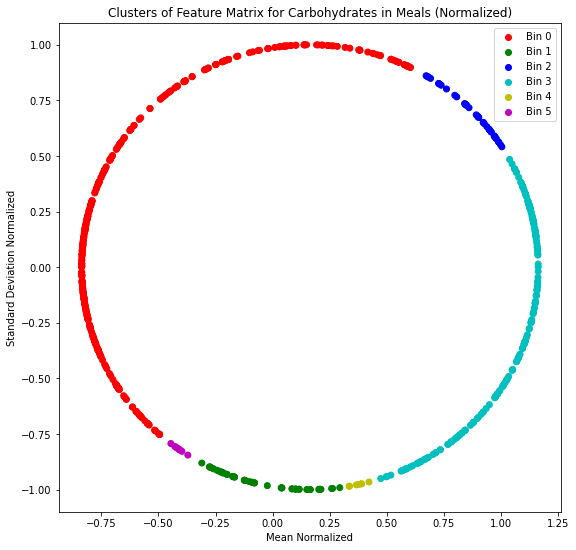

DBSCAN LABELS: 
[0 0 0 1 1 0 0 0 2 0 0 0 0 0 0 0 0 3 3 1 1 0 2 0 0 0 0 0 2 0 0 2 0 0 1 0 0
 0 0 3 3 0 0 0 0 0 3 3 2 3 3 3 3 3 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 2 2 0 0 0
 0 3 3 3 0 3 3 3 3 0 0 2 2 0 0 0 0 0 0 3 3 0 2 3 0 1 1 1 0 3 0 3 3 0 0 0 0
 0 0 0 0 0 3 0 0 0 3 0 0 3 3 0 0 0 3 3 0 0 0 0 0 0 0 3 1 1 0 3 3 0 0 0 0 3
 3 0 0 0 0 3 2 2 2 0 0 0 0 0 0 3 3 3 3 3 0 0 4 0 3 0 0 0 0 3 0 3 0 0 0 3 3
 2 3 3 3 3 0 3 3 3 3 3 0 0 0 0 0 0 0 0 0 3 0 0 3 0 1 1 0 0 0 3 0 0 2 3 3 0
 2 0 0 0 0 0 0 0 3 0 0 0 3 1 0 0 0 0 3 3 2 2 0 0 0 0 2 0 0 0 3 3 1 1 1 1 5
 0 0 3 0 0 0 0 0 5 0 0 3 3 0 0 1 0 3 3 3 0 0 0 3 1 0 0 3 0 0 0 0 2 0 3 3 2
 3 3 3 0 0 2 2 3 3 0 0 0 0 3 3 0 0 0 3 2 3 0 1 1 1 3 0 0 0 0 0 0 0 3 5 5 0
 0 0 3 3 3 0 0 5 5 5 0 2 3 1 4 3 0 3 0 0 0 3 0 0 0 0 4 0 0 0 5 0 0 0 0 0 0
 3 3 0 0 0 0 0 0 2 0 3 3 2 1 1 0 0 0 3 3 3 0 0 1 1 1 3 3 1 3 3 3 2 3 3 2 0
 3 3 3 3 0 0 4 1 1 2 2 3 0 0 4 4 3 3 0 0 0 0 3 3 3 3 3 0 0 0 0 0 0 0 0 3 3
 0 0 3 0 0 0 0 3 1 3 3 2 0 0 0 0 0 3 3 3 1 3 3 0 0 3 3 3 3 0 0 3 0 0 0 0 0
 0 0 3 1 

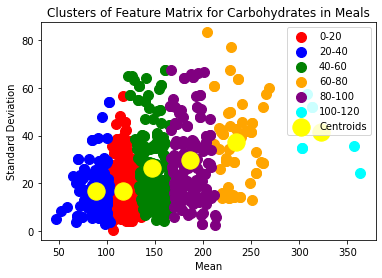

Kmeans SSE: 2772
Kmeans Entropy: 1.5676043739536658
Kmeans Purity: 0.32887700534759357


NameError: name 'Workbook' is not defined

In [14]:
#Finding tm times
tm_list_date, tm_list_time, tm_list_row = get_tm_times(ins_P1)

#Finding meal list start and end times
meal_list_date, meal_list_time, meal_list_row = indicate_meal_boundaries(tm_list_date, tm_list_time, tm_list_row)
    
#Extracting features from meal and no meal data
means, sds, ground_truths = extract_features(meal_list_date, meal_list_time, meal_list_row, cgm_P1)
#Making features same length as y-column for clustering algorithm:
means = means[:len(means) - 274]
sds = sds[:len(sds) - 274]
ground_truths = ground_truths[:len(ground_truths) - 274]

#Creating features dataframe as input for ml classification model
features_df = create_features_df(means, sds, ground_truths)

#Making meal data the same length as y-column for clustering algorithm:
meal_list_row = meal_list_row[:len(meal_list_row) - 584]

#print(features_df)
#Finding max and min values
minimum, maximum, y_list = find_Min_Max(ins_P1) 
print("Minimum: " + str(minimum))
print("Maximum: " + str(maximum) + "\n")
#print("y indices length: ")
#print(len(y_list))

#Discretizing values
n, y_list_discretized = discretize(minimum, maximum, meal_list_row, y_list) 
print("Number of bins: " + str(n) + "\n")
#print("Ground Truth Labels: ")
#print(y_list_discretized)
#print("y column discretized: ")
#print(y_list_discretized) #This is the ground truth values for the meal data 
#print("Meal Boundaries Length: " + "\n")
#print(len(meal_list_row) / 2) #1040

#Preprocessing data
X_principal = preprocessing(features_df)

#Clustring feature matrix using DBSCAN
dbscan_label = dbscan(X_principal, y_list_discretized)
print("DBSCAN LABELS: ")
print(dbscan_label)
#Retrieving metrics for dbscan algorithm
sse_dbscan, entropy_dbscan, purity_dbscan = metrics(dbscan_label, y_list_discretized)
print("DBSCAN SSE: " + str(sse_dbscan))
print("DBSCAN Entropy: " + str(entropy_dbscan))
print("DBSCAN Purity: " + str(purity_dbscan) + "\n")

#Clustering feature matrix using KMeans
#kmeans_label = kmeans(X_principal, y_list_discretized)
kmeans_label = kmeans(features_df, y_list_discretized)
#print("KMEANS LABELS: ")
#print(kmeans_label)
#Retrieving metrics for kmeans algorithm
sse_kmeans, entropy_kmeans, purity_kmeans = metrics(kmeans_label, y_list_discretized)
print("Kmeans SSE: " + str(sse_kmeans))
print("Kmeans Entropy: " + str(entropy_kmeans))
print("Kmeans Purity: " + str(purity_kmeans))

#Writing results to .csv file:
create_results_csv(sse_dbscan,entropy_dbscan, purity_dbscan, sse_kmeans, entropy_kmeans, purity_kmeans)

In [ ]:
print("DRIVER PROGRAM FINISHED COMPILING.")